In [14]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.fdsn import RoutingClient
from obspy import Stream
from obspy.geodetics import gps2dist_azimuth
from obspy import signal
from obspy import read
import matplotlib.pyplot as plt
import folium
import numpy as np
import json
import pandas as pd
from obspy.clients.fdsn.header import FDSNNoDataException
from scipy.signal import savgol_filter
import os
import folium
import numpy as np
import branca.colormap as cm

from obspy import Stream
from matplotlib.colors import LogNorm

import pandas as pd

Dtmin_Noise=-25
Dtmax_Noise=-5
Dtmin_Pn=-5.
Dtmax_Pn=10.
Dtmin_Sn=-5.
Dtmax_Sn=10.

vLg_max=3.5
vLg_min=3.1
vLg=0.5*(vLg_max+vLg_min)
vPg_max=6.2
vPg_min=5.2
vPg=0.5*(vPg_max+vPg_min)
print(vPg)
#vPg=6.

tminCoda=300.
tmaxCoda=320.

5.7


In [15]:
from new_functions import get_data2, big_downloader2, calc_amps, plot_stations_amps, plot_record_section, SNR_all, select_ratio, select_ratio_dict, update_event_file

To do: 
- plot the enevelopes

<class 'numpy.ndarray'>


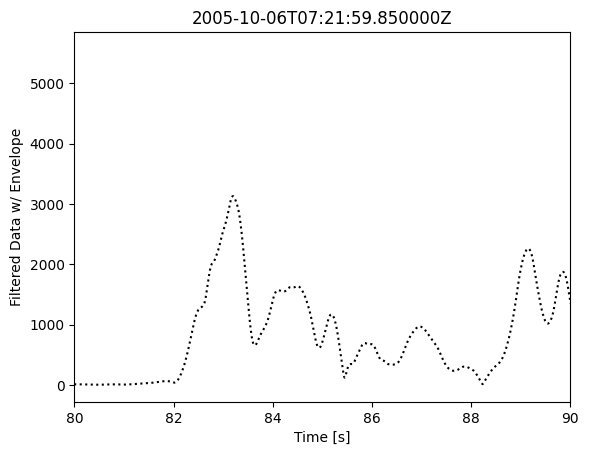

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import obspy
import obspy.signal


st = obspy.read("https://examples.obspy.org/RJOB_061005_072159.ehz.new")
data = st[0].data
npts = st[0].stats.npts
samprate = st[0].stats.sampling_rate

# Filtering the Stream object
st_filt = st.copy()
st_filt.filter('bandpass', freqmin=1, freqmax=3, corners=2, zerophase=True)

# Envelope of filtered data
data_envelope = obspy.signal.filter.envelope(st_filt[0].data)
print(type(data_envelope))

# The plotting, plain matplotlib
t = np.arange(0, npts / samprate, 1 / samprate)
#plt.plot(t, st_filt[0].data, 'k')
plt.plot(t, data_envelope, 'k:')
plt.title(st[0].stats.starttime)
plt.ylabel('Filtered Data w/ Envelope')
plt.xlabel('Time [s]')
plt.xlim(80, 90)
plt.show()

#### Choose large earthquakes


In [17]:

catalogue_5 = pd.read_csv('/home/schreinl/Stage/Data/eq_4_france.csv')
catalogue_5 = catalogue_5[catalogue_5['mag'] >= 4.0].reset_index(drop=True)
print(len(catalogue_5))
carte = folium.Map([45, 7], zoom_start=5)

for _, row in catalogue_5.iterrows():
    infos = f"{row['time']} ({row['latitude']}, {row['longitude']}) {row['mag']} m"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        tooltip=infos,
        fill=True,
        fill_opacity=1.0,
        radius=4,
    ).add_to(carte)

carte


95


In [18]:
#import warnings
#warnings.filterwarnings("ignore")
datacenters =['RESIF','ODC','ETH','INGV','GEOFON', 'IRIS', 'ICGC']#,'BGR']
directory='C:/UGA/Stage/Data/'
distmin=1.9
distmax=10.
start = UTCDateTime(catalogue_5['time'][11])
end = start + 700
eq_lon = float(catalogue_5['longitude'][11])
eq_lat = float(catalogue_5['latitude'][11])
st_all, stations_all, plot = big_downloader2(datacenters, start, end, eq_lon, eq_lat, distmin, distmax, directory, plot=False)
time_string = UTCDateTime.strftime(start, format="%Y_%m_%dT%H_%M_%S")


Earthquake at 2023-03-22T14:50:33.025000Z with magnitude 4.4


Processing stations of GEOFON:   2%|▏         | 2/133 [00:05<05:38,  2.58s/it]/home/schreinl/.local/lib/python3.10/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
Processing stations of IRIS:   7%|▋         | 11/148 [00:04<00:39,  3.45it/s]/home/schreinl/.local/lib/python3.10/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
Processing stations of ICGC:   0%|          | 0/25 [00:00<?, ?it/s]/home/schreinl/.local/lib/python3.10/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
Processing stations

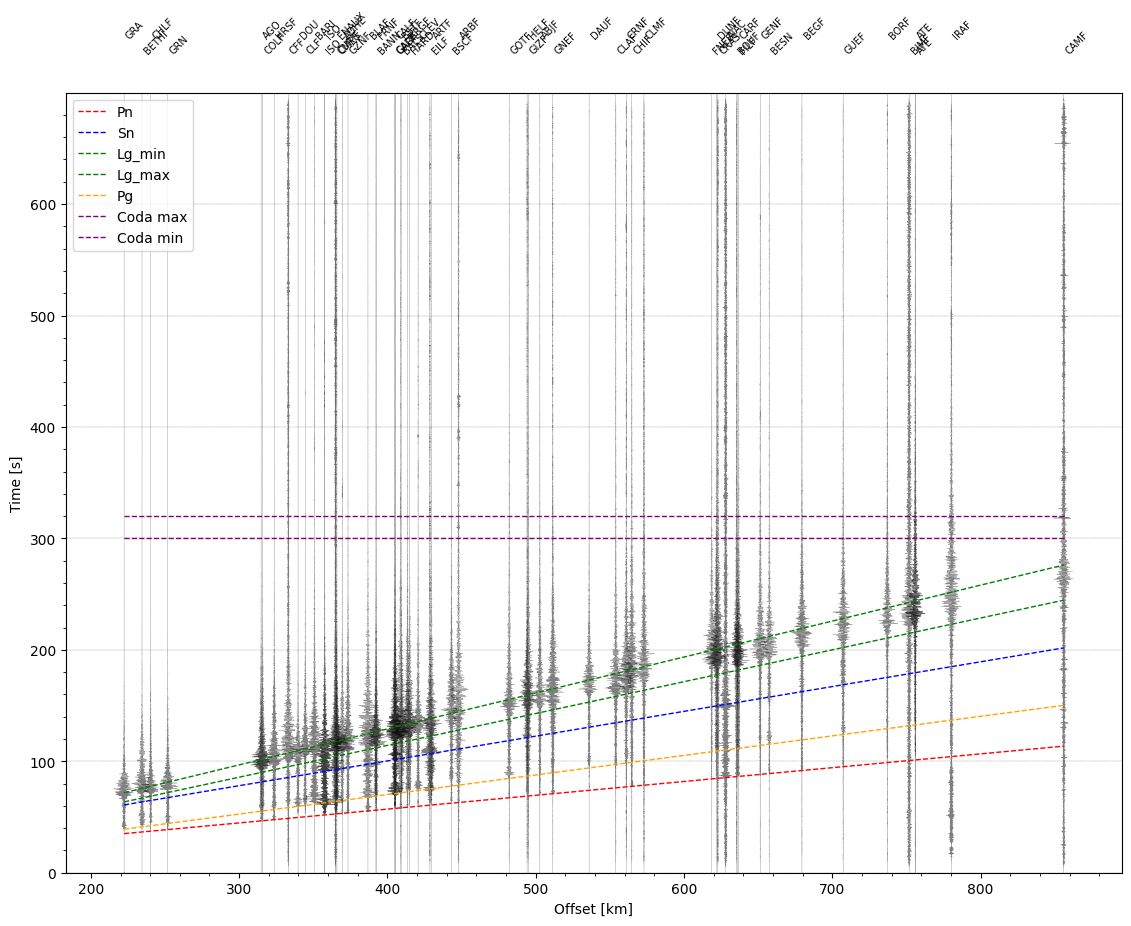

In [19]:
st_plot_filt_all=st_all.copy()
fmin=1
fmax=5
st_plot_filt_all.filter("bandpass", freqmin=fmin, freqmax=fmax)


plot, st_Lg0 = plot_record_section(st_plot_filt_all[0:60], stations_all[0:60], eq_lat, 
eq_lon, start, tracehodo=True, v_Lg_min=vLg_min, v_Lg_max=vLg_max, 
v_Pg=vPg)

In [8]:
print(len(st_plot_filt_all))

784


Choose now one station for a large event, plot the envelope and find the linear regime in the decay.
Then several stations can be plotted, the ratio and the coda amplitude ratio.


In [20]:
import obspy
from scipy.fftpack import hilbert
import numpy as np
#from obspy.signal.filter import envelope
from scipy.signal import resample


def envelope_calculator(data):
    hilb = hilbert(data)
    data = (data ** 2 + hilb ** 2) ** 0.5
    return data

st_envelope = obspy.Stream()
smallest = 7000
for tr in st_plot_filt_all:
    data_envelope = envelope_calculator(tr.data)
    npts = tr.stats.npts
    if npts >= smallest:
        samprate = tr.stats.sampling_rate
        t = np.arange(0, npts / samprate, 1 / samprate)
        tr_envelope = obspy.Trace(data=data_envelope, header=tr.stats)
        #data_resampled = resample(tr_envelope.data, 10000)
        #tr_resampled = obspy.Trace(data=data_resampled, header=tr.stats)
        st_envelope.append(tr_envelope)
#st_envelope.write(f'/home/schreinl/Stage/Data/Envelopes/{time_string}_envelopes.mseed')





In [10]:
print(st_envelope[16].stats.station) #CI19 good for La Rochelle event

BORF


151
577


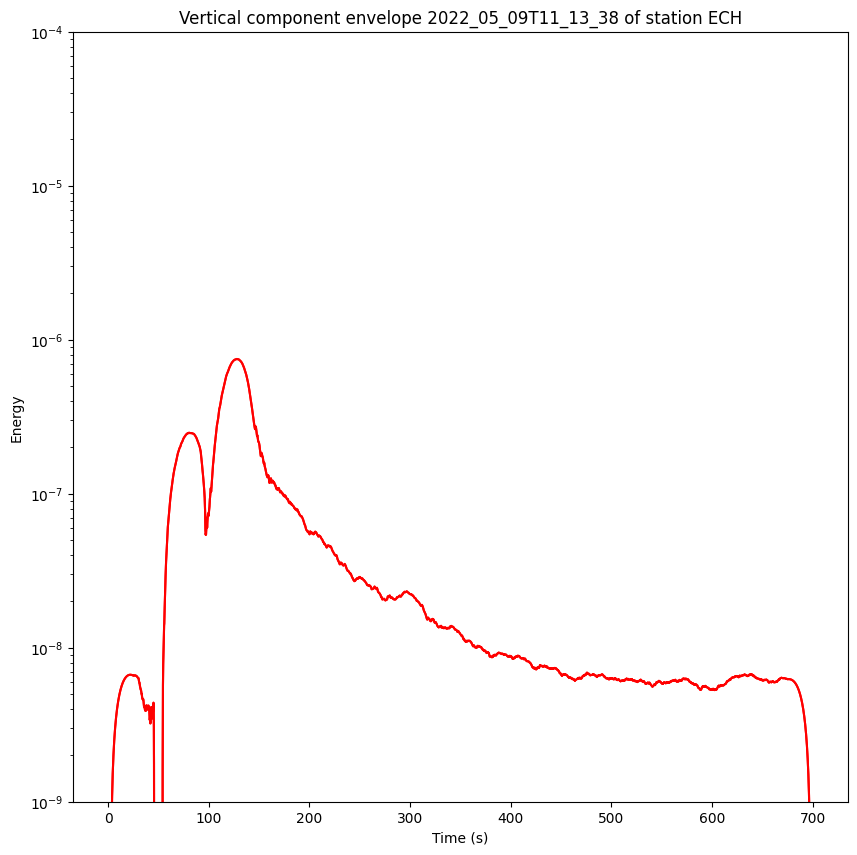

In [11]:
station = "ECH"
plt.figure(figsize=(10,10))
for i,tr in enumerate(st_envelope):
    if tr.stats.station == station:
        idx_reference = i
        print(i)
        npts = len(tr.data)
        samprate = tr.stats.sampling_rate #10000/700 
        t = np.arange(0, npts / samprate, 1 / samprate)

        #use a stable window length in s, while the window lenght in samples is dependant on the sample rate
        
        window_length = 50*samprate #min(2000, npts)
        if window_length % 2 == 0:
            window_length -= 1
        yhat = savgol_filter(tr.data, int(window_length), 3) 
        t = t[:len(yhat)]
        plt.title(f"Vertical component envelope {time_string} of station {station}")
        plt.ylabel("Energy")
        plt.xlabel("Time (s)")
        #plt.semilogy(t,st_envelope[i])
        plt.semilogy(t,yhat, color='red')
        plt.ylim([1e-9,1e-4])
        #plt.xlim([100,350])
plt.show()


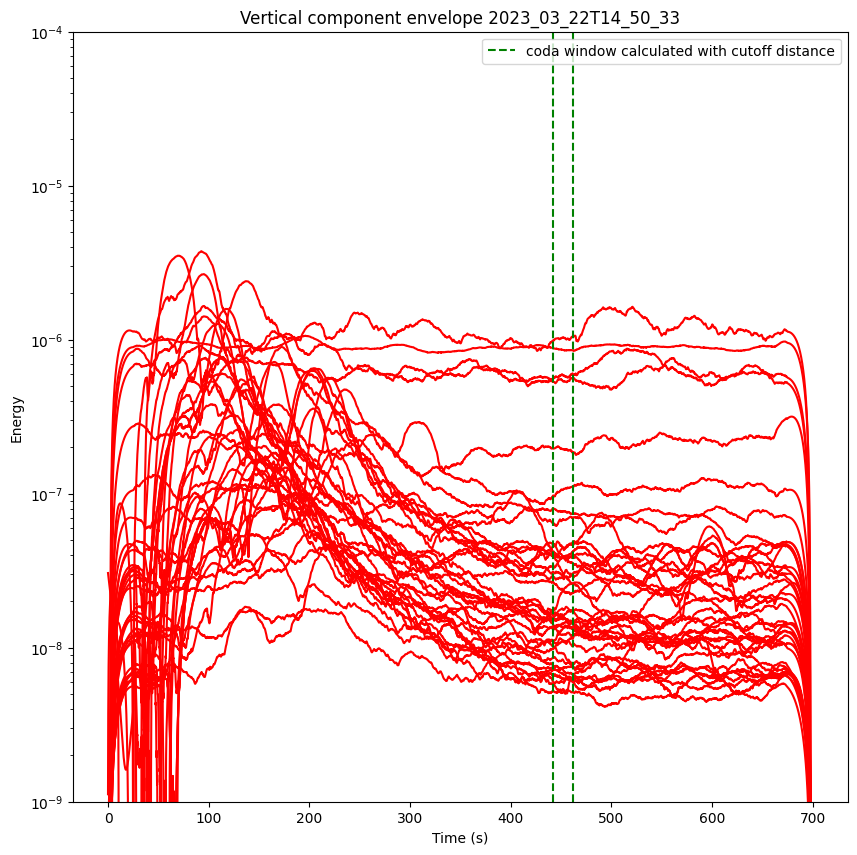

In [21]:
from scipy.signal import savgol_filter
from random import randint
def smooth_plot_envelope(time_string, n_traces,st_envelope,tmincoda_dist=442, tmaxcoda_dist=462,plotshow=False, savefig=True):
    testing = [(randint(1, len(st_plot_filt_all))) for i in range(n_traces)]

    plt.figure(figsize=(10,10))
    for i in testing:
        if i < len(st_envelope):
            npts = len(st_envelope[i].data)
            samprate = st_envelope[i].stats.sampling_rate #10000/700 
            t = np.arange(0, npts / samprate, 1 / samprate)

            #use a stable window length in s, while the window lenght in samples is dependant on the sample rate
            
            window_length = min(50*samprate, npts) # Ensure window_length is not greater than npts
            if window_length % 2 == 0:
                window_length -= 1
            yhat = savgol_filter(st_envelope[i].data, int(window_length), 3) 
            t = t[:len(yhat)]

            #plt.semilogy(t,st_envelope[i])
            plt.semilogy(t,yhat, color='red')
            plt.ylim([1e-9,1e-4])
            plt.title(f"Vertical component envelope {time_string}")
            plt.ylabel("Energy")
            plt.xlabel("Time (s)")
            #plt.xlim([100,350])
    plt.vlines(tmaxcoda_dist,ymax=1e-4,ymin=1e-9, label='coda window calculated with cutoff distance',colors='g',linestyles='--')
    plt.vlines(tmincoda_dist,ymax=1e-4,ymin=1e-9,colors='g',linestyles='--')
    #plt.vlines(350,ymax=1e-4,ymin=1e-9, label='coda window similar to Galina&Shapiro 2024',colors='b',linestyles='--')
    #plt.vlines(470,ymax=1e-4,ymin=1e-9,colors='b',linestyles='--')
    plt.legend()
    if savefig:
        mag_dir = '/home/schreinl/Stage/Data/Metadata/'
        with open(f"{mag_dir}{time_string}.txt", "r") as meta:
            for line in meta:
                if line.startswith("Magnitude:"):
                    magnitude = float(line.split(":")[1].strip())
        plt.savefig(f'/home/schreinl/Stage/Figures/SiteEffect/multiple_envelopes_{time_string}_{magnitude}_filtered.png', format='png')
    if plotshow:
        plt.show()
    
    return  
tset = smooth_plot_envelope(time_string, 50,st_envelope)

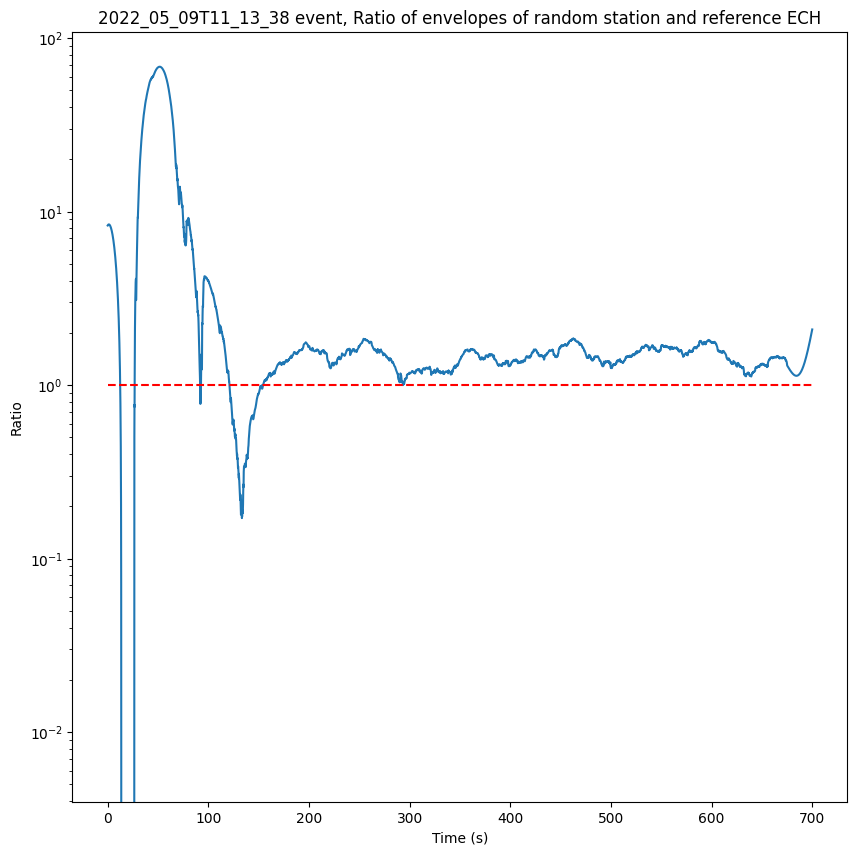

In [13]:
plt.figure(figsize=(10,10))
plt.semilogy(np.arange(0,700,0.01),savgol_filter(np.divide(resample(st_envelope[9].data,70000),resample(st_envelope[idx_reference].data,70000)),5000,3))
plt.title(f"{time_string} event, Ratio of envelopes of random station and reference ECH")
plt.xlabel('Time (s)')
plt.ylabel('Ratio')
plt.hlines(1,xmin=0,xmax=700, linestyles="--",colors='r')

#### Routine
Now implement a routine, which, for a given event, gets the data, filters it, calculates the envelope for each trace and writes it in a stream. Then a second stream is initialised, where all the envelopes are smoothed. These streams can be written to disk. Plot the coda amplitude ratio (from disk) of all stations in relation to the same station, and the envelope ratio with the same ratio against each other. Then plot the coda amp ratio of a specific ratio over magnitudes. 

For the amplitude ratios, choose a time window of length 120s, then calculate the amplitude ratio and its mean.

In [28]:
from scipy.signal import savgol_filter
import numpy as np
import obspy

def envelopes_routine1(event, st_envelope, codastart=350, codaend=470, coda_dist_start=300, coda_dist_end=350, plotting=False, n_traces=50):
    '''
    Takes as input a stream with the envelopes. It subsequently calculates the smoothed envelopes with a moving averaging
    window of 50s. These smooth envelopes are put in a new stream.
    '''
    st_envelope_smooth = obspy.Stream()
    
    for trace in st_envelope:
        npts = len(trace.data)
        samprate = trace.stats.sampling_rate
        t = np.arange(0, npts / samprate, 1 / samprate)

        window_length = min(50 * samprate, npts) 
        if window_length % 2 == 0:
            window_length -= 1
        
        yhat = savgol_filter(trace.data, int(window_length), 3) 
        t = t[:len(yhat)]

        tr_envelope_smooth = obspy.Trace(data=yhat, header=trace.stats)
        st_envelope_smooth.append(tr_envelope_smooth)

    if plotting:
        smooth_plot_envelope(event, n_traces, st_envelope_smooth)

    station_data = {}

    for trace in st_envelope_smooth:
        dt = trace.stats.delta
        startcoda = int(codastart / dt) 
        endcoda = int(codaend / dt) 
        startcoda_dist = int(coda_dist_start / dt)
        endcoda_dist = int(coda_dist_end / dt)

        if startcoda >= len(trace.data) or endcoda > len(trace.data) or startcoda >= endcoda:
            continue

        coda = trace.data[startcoda:endcoda]
        coda_dist = trace.data[startcoda_dist:endcoda_dist]

        if len(coda) < 2 or len(coda_dist) < 2:
            continue  

        x_coda = np.linspace(0, (len(coda) - 1) * dt, len(coda))
        x_coda_dist = np.linspace(0, (len(coda_dist) - 1) * dt, len(coda_dist))

        coef_coda = np.polyfit(x_coda, coda, 1) if not np.all(coda == coda[0]) else [0, 0]
        coef_coda_dist = np.polyfit(x_coda_dist, coda_dist, 1) if not np.all(coda_dist == coda_dist[0]) else [0, 0]

        station_name = trace.stats.station 
        amplitude = (np.sqrt(np.dot(coda_dist, coda_dist.T)) / len(coda_dist))
        
        station_data[station_name] = {
            "amplitude": amplitude,
            "coda_slope": coef_coda[0],
            "coda_dist_slope": coef_coda_dist[0]
        }

    return station_data, st_envelope_smooth

#envelopes_amps, st_smooth = envelopes_routine1(time_string, st_envelope, ref_idx=idx_reference, plotting=False)
#print(envelopes_amps)


In [ ]:

from scipy.signal import savgol_filter

def envelopes_routine(event, st_envelope, ref_idx, codastart=350, codaend=470, coda_dist_start=300, coda_dist_end=350, plotting=False, n_traces=50):
    '''
    Takes as input a stream with the envelopes. It subsequently calculates the smoothed envelopes with a moving averaging
    window of 50s. These smooth envelopes are put in a new stream.
    
    '''
    st_envelope_smooth = obspy.Stream()
    
    for trace in st_envelope:
        npts = len(trace.data)
        samprate = trace.stats.sampling_rate
        t = np.arange(0, npts / samprate, 1 / samprate)

        window_length = min(50 * samprate, npts) 
        if window_length % 2 == 0:
            window_length -= 1
        
        yhat = savgol_filter(trace.data, int(window_length), 3) 
        t = t[:len(yhat)]

        tr_envelope_smooth = obspy.Trace(data=yhat, header=trace.stats)
        st_envelope_smooth.append(tr_envelope_smooth)

    if plotting:
        smooth_plot_envelope(event, n_traces, st_envelope_smooth)

    station_data = {}

    for trace in st_envelope_smooth:
        dt = trace.stats.delta
        startcoda = int(codastart / dt) 
        endcoda = int(codaend / dt) 
        startcoda_dist = int(coda_dist_start / dt)
        endcoda_dist = int(coda_dist_end / dt)
        if startcoda >= len(trace.data) or endcoda > len(trace.data):
            continue

        coda = trace.data[startcoda:endcoda]
        coda_dist = trace.data[startcoda_dist:endcoda_dist]
        coef_coda = np.polyfit(np.arange(len(coda)),coda,1)
        coef_coda_dist = np.polyfit(np.arange(len(coda_dist)),coda_dist,1)
        ref = st_envelope_smooth[ref_idx].data[startcoda:endcoda]

        station_name = trace.stats.station 
        #amplitude_ratio = (np.sqrt(np.dot(coda, coda.T)) / len(coda)) / \
        #                  (np.sqrt(np.dot(ref, ref.T)) / len(ref))
        amplitude = (np.sqrt(np.dot(coda, coda.T)) / len(coda))
        
        
        station_data[station_name] = {
            "amplitude": amplitude,
            "coda_slope": coef_coda[0],
            "coda_dist_slope": coef_coda_dist[0]
        }

    return station_data

envelopes_amps = envelopes_routine(time_string, st_envelope, ref_idx=idx_reference, plotting=False)
print(envelopes_amps)


{'GRA': {'amplitude': 2.0144781845853664e-10, 'coda_slope': 1.1574484849390297e-13, 'coda_dist_slope': 3.612610208759696e-13}, 'CI18': {'amplitude': 9.804684630924879e-11, 'coda_slope': 6.816010931504663e-14, 'coda_dist_slope': -5.752769645098425e-13}, 'CI19': {'amplitude': 1.2314567374406335e-10, 'coda_slope': -1.6971748581509582e-13, 'coda_dist_slope': -1.9797321138266688e-13}, 'CI20': {'amplitude': 5.60829648010247e-10, 'coda_slope': 2.475255355912114e-13, 'coda_dist_slope': -2.8107140997585358e-12}, 'AJAC': {'amplitude': 2.1884481092019812e-10, 'coda_slope': 2.782816500874247e-13, 'coda_dist_slope': -5.772043310683387e-13}, 'ARBF': {'amplitude': 4.923134348338346e-10, 'coda_slope': -1.7845811966845316e-12, 'coda_dist_slope': 9.983389276029176e-13}, 'ARTF': {'amplitude': 2.799450353555424e-10, 'coda_slope': -1.5631447431514434e-12, 'coda_dist_slope': -5.682674335869423e-12}, 'ATE': {'amplitude': 9.282362010616451e-11, 'coda_slope': -6.116039926661493e-13, 'coda_dist_slope': -3.23117

In [23]:
snr_threshold = 2
eq_start = start

filtered_stations_with_SNR, stations_with_SNR, distance_dict, tcoda_test, filtered_st, stations_with_amps, amp_plot = SNR_all(stations_all, st_plot_filt_all, Dtmin_Pn, Dtmax_Pn, Dtmin_Sn, Dtmax_Sn, vLg_min,vLg_max,vPg_min, vPg_max, tminCoda, tmaxCoda,
         Dtmin_Noise, Dtmax_Noise,eq_start,eq_lat,eq_lon,snr_threshold=snr_threshold,plot_SNR=False,plot_amps=True, wavecode="Lg_Coda",dB=True,codawindow="cutoff",factor=1.3)

print(tcoda_test)
with open(f"/home/schreinl/Stage/Data/Dicts/{time_string}_{snr_threshold}_thresh_dict.txt", "w") as file:
        json.dump(distance_dict, file, indent=4)

    
    # Save stations_with_amps to a file
with open(f"/home/schreinl/Stage/Data/{time_string}/{time_string}_{snr_threshold}_thresh_stations_with_amps.txt", "w") as ampls:
    json.dump(stations_with_amps.tolist(), ampls, indent=4)

    # Save filtered stations with their corresponding SNR
with open(f"/home/schreinl/Stage/Data/{time_string}/{time_string}_{snr_threshold}_thresh_filtered_stations_SNR.txt", "w") as snrfile:
    json.dump(filtered_stations_with_SNR.tolist(), snrfile, indent=4)

    # Save the stations with SNR, unfiltered
with open(f"/home/schreinl/Stage/Data/{time_string}/{time_string}_unfiltered_stations_SNR.txt", "w") as unsnrfile:
    json.dump(stations_with_SNR.tolist(), unsnrfile, indent=4)

amp_plot

calculating SNR for Pn  phase


/home/schreinl/Stage/Scripts/new_functions.py:663: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectPn,np.transpose(dataselectPn)))/len(dataselectPn)
/home/schreinl/Stage/Scripts/new_functions.py:664: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)
/home/schreinl/Stage/Scripts/new_functions.py:695: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectPg,np.transpose(dataselectPg)))/len(dataselectPg)
/home/schreinl/Stage/Scripts/new_functions.py:696: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


calculating SNR for Pg  phase
calculating SNR for Sn  phase


/home/schreinl/Stage/Scripts/new_functions.py:679: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectSn,np.transpose(dataselectSn)))/len(dataselectSn)
/home/schreinl/Stage/Scripts/new_functions.py:680: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)
/home/schreinl/Stage/Scripts/new_functions.py:647: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectLg,np.transpose(dataselectLg)))/len(dataselectLg)
/home/schreinl/Stage/Scripts/new_functions.py:648: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


calculating SNR for Lg  phase
Reduced from   561  stations to   399  stations due to insufficient SNR or distance >  703.627951300341
coda window set from 305.320098983623-355.320098983623s based on Lg cutoff distance
plotting Lg_Coda amplitudes
305.320098983623


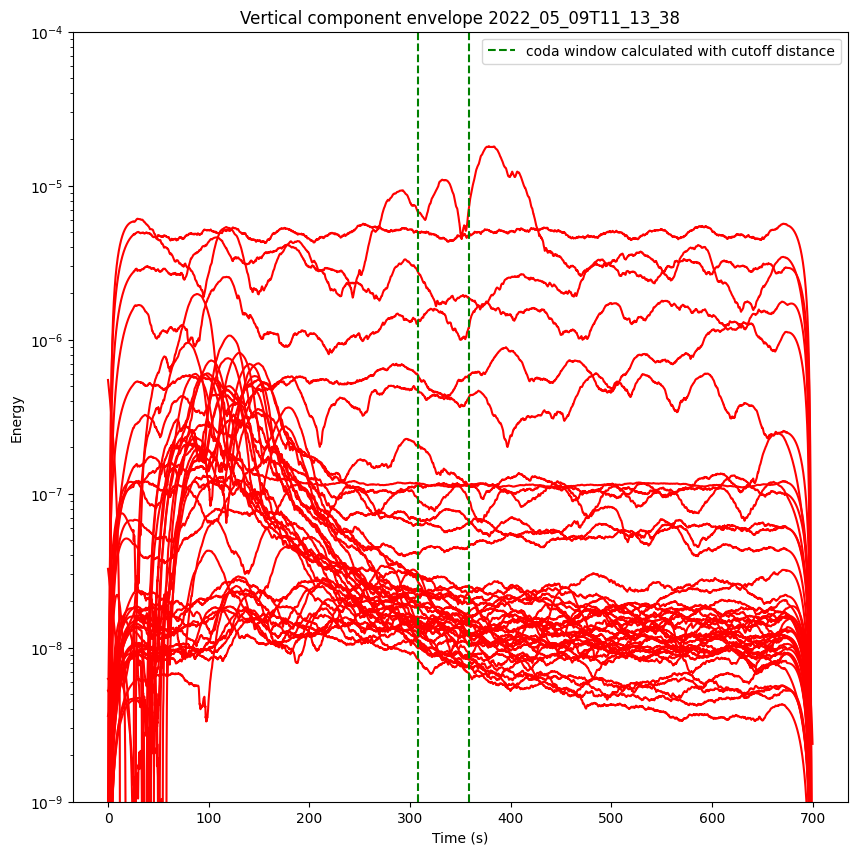

In [17]:
tset = smooth_plot_envelope(time_string, 50,st_envelope, tmincoda_dist=tcoda_test, tmaxcoda_dist=tcoda_test+50)

In [18]:
with open(f"/home/schreinl/Stage/Data/{time_string}/{time_string}_{snr_threshold}_thresh_stations_with_amps.txt", "r") as file:
    amplitude_stations = json.load(file)

amplitude_stations = np.array(amplitude_stations)
coda_amp = select_ratio_dict('Coda', amplitude_stations)
common_stations = set(coda_amp.keys()) & set(envelopes_amps.keys())
#SNR_filtered_smoothed_envelope_st = 
coda_envelope_amp_dict = {
    station: (coda_amp[station], envelopes_amps[station]["amplitude"])
    for station in common_stations
}

print(coda_envelope_amp_dict)

file_path = "envelope350_470_coda.csv"
event_name = time_string

update_event_file(file_path, event_name, coda_envelope_amp_dict)


{'RSP': (3.204281396235853e-10, 2.1727085565013713e-10), 'SURF': (1.0565359013710486e-10, 6.606657666917451e-11), 'CI20': (6.830371575575409e-10, 5.608296480102468e-10), 'ETSF': (1.3514758464134846e-10, 6.473848853180294e-11), 'DAVA': (3.85796603241684e-10, 2.5923516982001193e-10), 'ISO': (9.064940018431966e-11, 5.065698521143027e-11), 'XBFO': (2.3911997056729434e-10, 1.1816897340965152e-10), 'CARA': (1.724129196280746e-10, 9.753529819181544e-11), 'STV': (4.547659174416688e-10, 2.1267074051115552e-10), 'BANN': (1.416102708539634e-10, 7.54679241370814e-11), 'OGVG': (1.0768091617813826e-10, 6.126067528796493e-11), 'WOLEN': (7.097481388184393e-10, 5.530270785319018e-10), 'WALHA': (2.497853582942305e-10, 1.9590831111909657e-10), 'DOSS': (1.5284675270696426e-10, 1.308445160907805e-10), 'CANO': (5.862799874249773e-10, 4.067079870910881e-10), 'MON': (1.994970990194882e-09, 1.6040940266353667e-09), 'DUDEL': (1.6892970981683868e-09, 1.1894844874910856e-09), 'FETA': (2.1901786541858383e-10, 1.93

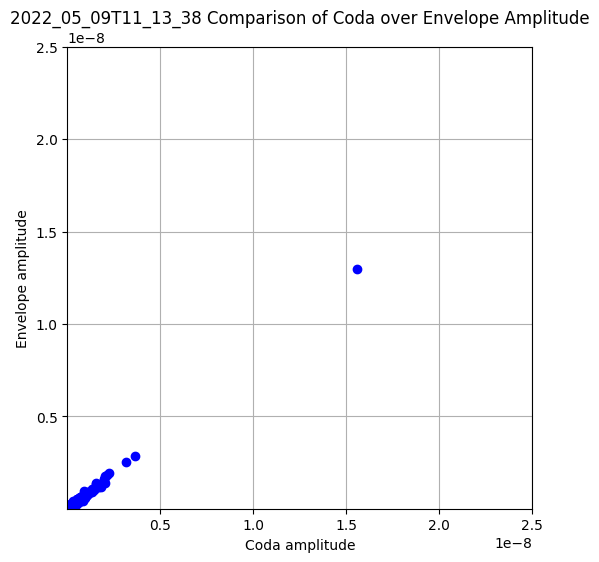

In [19]:
coda = [coda_amp[station] for station in common_stations]
envelope = [envelopes_amps[station]["amplitude"] for station in common_stations]



plt.figure(figsize=(6, 6))
plt.scatter(coda, envelope, color='b', label='Common Stations coda over envelope amplitude')

plt.xlabel('Coda amplitude')
plt.ylabel('Envelope amplitude')
plt.title(f'{time_string} Comparison of Coda over Envelope Amplitude')

#for station, x, y in zip(common_stations, coda, envelope):
#    plt.annotate(station, (x, y), textcoords="offset points", xytext=(5, 5), ha='right')

#plt.legend()
plt.xlim([1e-14,25e-9])
plt.ylim([1e-14,25e-9])
plt.grid(True)
plt.show()

304
304
slope is  1.3564607270829


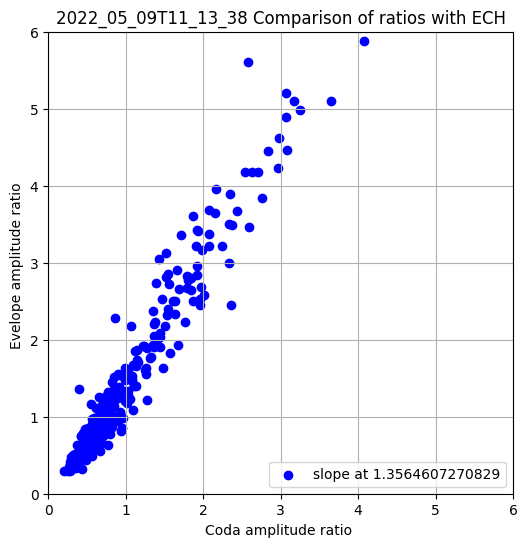

In [20]:
reference_station = 'ECH'

if reference_station in coda_amp and reference_station in envelopes_amps:
    ref_coda = coda_amp[reference_station]
    ref_envelope = envelopes_amps[reference_station]["amplitude"]
    common_stations = set(coda_amp.keys()) & set(envelopes_amps.keys()) - {reference_station}

    coda_ratio = [coda_amp[station] / ref_coda for station in common_stations]
    envelope_ratio = [envelopes_amps[station]["amplitude"] / ref_envelope for station in common_stations]
    print(len(coda_ratio))
    print(len(envelope_ratio))
    coef1 = np.polyfit(coda_ratio,envelope_ratio,1)
    print("slope is ", coef1[0])
    plt.figure(figsize=(6, 6))
    plt.scatter(coda_ratio, envelope_ratio, color='b', label=f'slope at {coef1[0]}')

    plt.xlabel(f'Coda amplitude ratio ')
    plt.ylabel(f'Evelope amplitude ratio ')
    plt.title(f'{time_string} Comparison of ratios with {reference_station}')

    #for station, x, y in zip(common_stations, coda_ratio, envelope_ratio):
    #    plt.annotate(station, (x, y), textcoords="offset points", xytext=(5, 5), ha='right')

    plt.legend()
    plt.xlim([0,6])
    plt.ylim([0,6])

    plt.grid(True)
    plt.show()

else:
    print(f"Reference station {reference_station} not found in both dictionaries.")


In [ ]:


def update_event_file(file_path, event_name, station_data):
    """
    Update a CSV file with station-event data.
    
    :param file_path: Path to the CSV file.
    :param event_name: Name of the event (prefix for column names).
    :param station_data: Dictionary with station names as keys and tuples of values for the event.
    """
    # Load existing data if the file exists
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0)
    else:
        df = pd.DataFrame()

    col1 = f"{event_name}_coda"
    col2 = f"{event_name}_envelope"
    
    for col in [col1, col2]:
        if col not in df.columns:
            df[col] = 0.0 
    for station in station_data.keys():
        if station not in df.index:
            df.loc[station] = [0.0] * len(df.columns)

    df = df.astype({col1: float, col2: float})

    for station, (value1, value2) in station_data.items():
        df.at[station, col1] = float(value1)
        df.at[station, col2] = float(value2)

    df.to_csv(file_path)
    print(f"Updated {file_path} with event '{event_name}'.")



#coda_envelope_amp_dict = {station: (coda_amp[station], envelopes_amps[station]) for station in common_stations}

file_path = "envelope350_470_coda440_460.csv"
event_name = time_string

update_event_file(file_path, event_name, coda_envelope_amp_dict)





Updated envelope350_470_coda440_460.csv with event '2022_05_09T11_13_38'.


#### Testing with SNR filtered stations
If we have run envelope_routine, we have the amplitude of the coda in a specific window (two windows can be set), as well as the smoothed stream. We can run before the SNR routine, finding the tmin of the coda using the cutoff distance. We could compare with a global window we never change. 

In [29]:
snr_threshold = 2
eq_start = start
stationref = "ECH"


filtered_stations_with_SNR, stations_with_SNR, distance_dict, tcoda_test, filtered_st, stations_with_amps, amp_plot = SNR_all(stations_all, st_plot_filt_all, Dtmin_Pn, Dtmax_Pn, Dtmin_Sn, Dtmax_Sn, vLg_min,vLg_max,vPg_min, vPg_max, tminCoda, tmaxCoda,
         Dtmin_Noise, Dtmax_Noise,eq_start,eq_lat,eq_lon,snr_threshold=snr_threshold,plot_SNR=False,plot_amps=True, wavecode="Lg_Coda",dB=True,codawindow="cutoff", factor=1.3)

#print(filtered_stations_with_SNR)
for i,tr in enumerate(st_envelope):
    if tr.stats.station == stationref:
        idx_reference = i

envelopes_amps, st_smooth = envelopes_routine1(time_string, st_envelope,coda_dist_start=tcoda_test, coda_dist_end=tcoda_test + 50, plotting=False)

filtered_station_names = set(row[1] for row in filtered_stations_with_SNR) 
filtered_smooth_stream = obspy.Stream()
filtered_stream = obspy.Stream()
for trace in st_smooth:
    if trace.stats.station in filtered_station_names:
        filtered_smooth_stream.append(trace)
for trace in st_envelope:
    if trace.stats.station in filtered_station_names:
        filtered_stream.append(trace)




#for i,tr in enumerate(st_envelope_smooth_filtered):
#    if tr.stats.station == stationref:
#        idx_reference = i


calculating SNR for Pn  phase


/home/schreinl/Stage/Scripts/new_functions.py:663: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectPn,np.transpose(dataselectPn)))/len(dataselectPn)
/home/schreinl/Stage/Scripts/new_functions.py:664: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)
/home/schreinl/Stage/Scripts/new_functions.py:695: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectPg,np.transpose(dataselectPg)))/len(dataselectPg)
/home/schreinl/Stage/Scripts/new_functions.py:696: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


calculating SNR for Pg  phase
calculating SNR for Sn  phase


/home/schreinl/Stage/Scripts/new_functions.py:679: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectSn,np.transpose(dataselectSn)))/len(dataselectSn)
/home/schreinl/Stage/Scripts/new_functions.py:680: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


calculating SNR for Lg  phase


/home/schreinl/Stage/Scripts/new_functions.py:647: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectLg,np.transpose(dataselectLg)))/len(dataselectLg)
/home/schreinl/Stage/Scripts/new_functions.py:648: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


Reduced from   561  stations to   399  stations due to insufficient SNR or distance >  703.627951300341
coda window set from 305.320098983623-355.320098983623s based on Lg cutoff distance
plotting Lg_Coda amplitudes


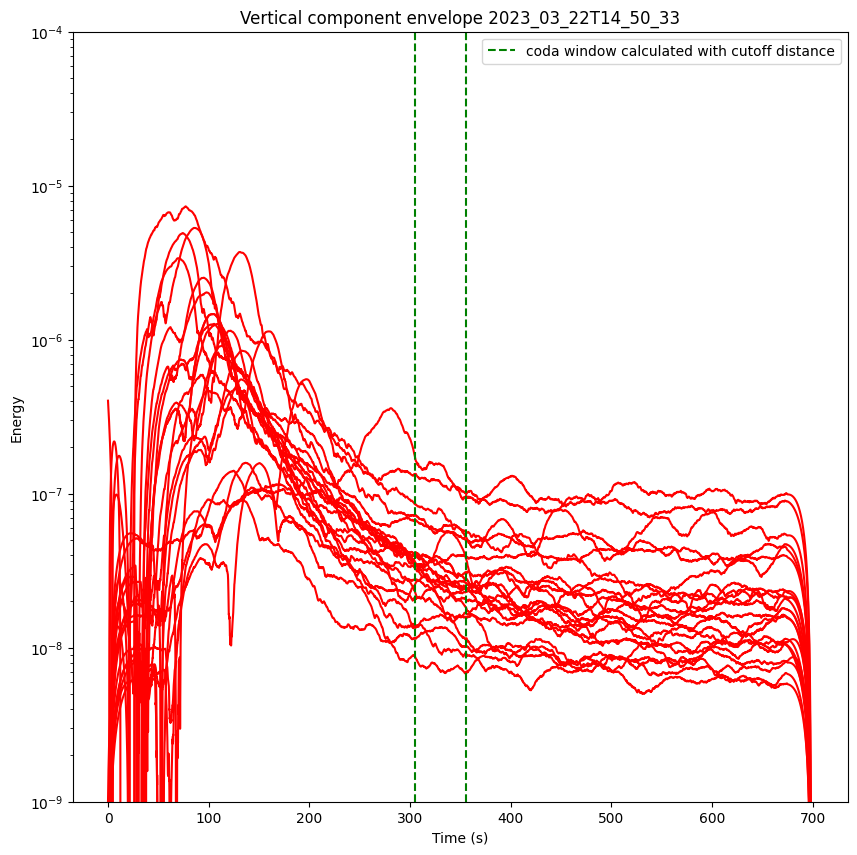

In [30]:
plot_filtered_smoothed = smooth_plot_envelope(time_string, 50,filtered_stream,tmincoda_dist=tcoda_test, tmaxcoda_dist=tcoda_test+50)

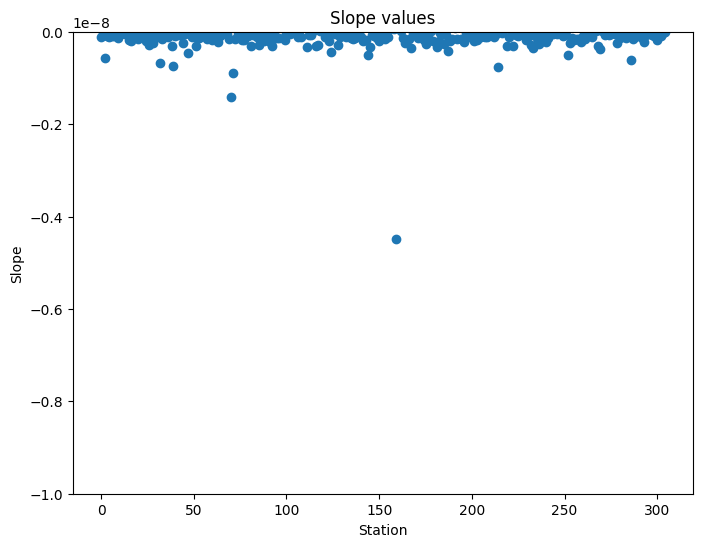

In [23]:
#envelopes_amps[station]["amplitude"]
#print(envelopes_amps)



common_stations = set(row[1] for row in filtered_stations_with_SNR) & set(envelopes_amps.keys())
slope_filt = [envelopes_amps[station]["coda_dist_slope"] for station in common_stations]
slope_filt_ampl = np.array(slope_filt) * 1e9
#vals_abs = np.abs(slope_filt)
plt.figure(figsize=(8, 6))
#bins = np.logspace(np.log10(vals_abs.min()), np.log10(vals_abs.max()), 15)
#plt.hist(slope_filt_ampl, bins=bins, edgecolor='black', alpha=0.7)

plt.scatter(np.arange(len(slope_filt)),slope_filt)

plt.ylabel("Slope")
plt.xlabel("Station")
plt.title("Slope values")
#plt.xscale("log")
plt.ylim([-1e-8,0])

plt.show()


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  2.,  1.,  2.,  2.,  3.,  6., 20., 39., 78., 86.]),
 array([-4.00e-09, -3.92e-09, -3.84e-09, -3.76e-09, -3.68e-09, -3.60e-09,
        -3.52e-09, -3.44e-09, -3.36e-09, -3.28e-09, -3.20e-09, -3.12e-09,
        -3.04e-09, -2.96e-09, -2.88e-09, -2.80e-09, -2.72e-09, -2.64e-09,
        -2.56e-09, -2.48e-09, -2.40e-09, -2.32e-09, -2.24e-09, -2.16e-09,
        -2.08e-09, -2.00e-09, -1.92e-09, -1.84e-09, -1.76e-09, -1.68e-09,
        -1.60e-09, -1.52e-09, -1.44e-09, -1.36e-09, -1.28e-09, -1.20e-09,
        -1.12e-09, -1.04e-09, -9.60e-10, -8.80e-10, -8.00e-10, -7.20e-10,
        -6.40e-10, -5.60e-10, -4.80e-10, -4.00e-10, -3.20e-10, -2.40e-10,
        -1.60e-10, -8.00e-11,  0.00e+00]),
 <BarContainer object of 50 artists>)

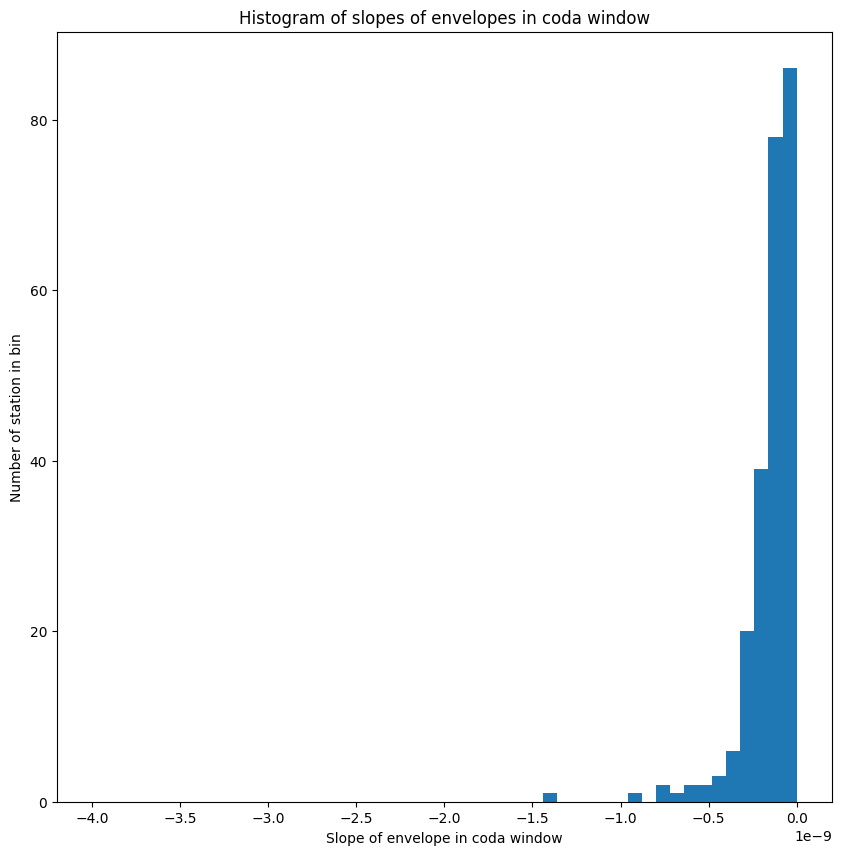

In [24]:
plt.figure(figsize=(10,10))
plt.xlabel('Slope of envelope in coda window')
plt.ylabel('Number of station in bin')
plt.title('Histogram of slopes of envelopes in coda window')
plt.hist(slope_filt,bins=50,range=(-4e-9,0))

In [ ]:
def check_availability(eq_list, station_name):
    download_counter = 0
    no_data_counter = 0
    not_listed_counter = 0

    for event in eq_list:
        time_string = UTCDateTime.strftime(event, format="%Y_%m_%dT%H_%M_%S")

        with open(f"C:/UGA/Stage/Data/{time_string}/{time_string}.txt", "r") as file:
            availability = json.load(file)

        with open(f"{mag_dir}{time_string}.txt", "r") as meta:
            for line in meta:
                if line.startswith("Magnitude:"):
                    magnitude = float(line.split(":")[1].strip())
                    mags.append(magnitude)
        

In [ ]:
import os
import csv
import pandas as pd

output_file = "event_summary.csv"
event_catalog = pd.read_csv('/home/schreinl/Stage/Data/eq_4_france.csv') 
data_dir = "/home/schreinl/Stage/Data"

event_times = event_catalog["time"].astype(str).tolist() 

with open(output_file, "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Time", "Available", "Not Available", "Not Listed"])

    for event_time in event_times:
        event_dir = os.path.join(data_dir, event_time)
        event_file = os.path.join(event_dir, f"{event_time}.txt")

        available = 0
        not_available = 0
        not_listed = 0

        if os.path.exists(event_file):
            with open(event_file, "r") as ef:
                for line in ef:
                    parts = line.strip().split(",")
                    if len(parts) != 2:
                        continue  

                    station, status = parts

                    if status.lower() == "downloaded":
                        available += 1
                    elif status in ["204", "404"]:
                        not_available += 1
                    else:
                        not_listed += 1
        else:
            not_listed += 1

        csv_writer.writerow([event_time, available, not_available, not_listed])

print(f"Summary written to {output_file}")


Summary written to event_summary.csv


### Big Loop over Envelopes




event 0  out of  15
Earthquake at 2025-01-12T13:51:40.650000Z with magnitude 4.3


Processing stations of ICGC: 100%|██████████| 25/25 [00:01<00:00, 24.30it/s]


calculating SNR for Pn  phase
calculating SNR for Pg  phase
calculating SNR for Sn  phase
calculating SNR for Lg  phase
Reduced from   628  stations to   396  stations due to insufficient SNR or distance >  833.7295845430684
coda window set from 337.75885799073325-387.75885799073325s
plotting Lg_Coda amplitudes
event 1  out of  15
Earthquake at 2024-06-04T00:34:32.581000Z with magnitude 4.2


Processing stations of ICGC: 100%|██████████| 24/24 [00:01<00:00, 20.13it/s]


calculating SNR for Pn  phase
calculating SNR for Pg  phase
calculating SNR for Sn  phase
calculating SNR for Lg  phase
Reduced from   631  stations to   501  stations due to insufficient SNR or distance >  801.7321792415729
coda window set from 347.08449314801396-397.08449314801396s
plotting Lg_Coda amplitudes
event 2  out of  15
Earthquake at 2024-06-04T00:34:32.581000Z with magnitude 4.2


Processing stations of ICGC: 100%|██████████| 24/24 [00:01<00:00, 20.48it/s]


calculating SNR for Pn  phase
calculating SNR for Pg  phase
calculating SNR for Sn  phase
calculating SNR for Lg  phase
Reduced from   631  stations to   501  stations due to insufficient SNR or distance >  801.7321792415729
coda window set from 347.08449314801396-397.08449314801396s
plotting Lg_Coda amplitudes
event 3  out of  15
Earthquake at 2024-03-27T21:19:37.385000Z with magnitude 4.3


Processing stations of ICGC: 100%|██████████| 24/24 [00:06<00:00,  3.82it/s]


calculating SNR for Pn  phase
calculating SNR for Pg  phase
calculating SNR for Sn  phase
calculating SNR for Lg  phase
Reduced from   624  stations to   473  stations due to insufficient SNR or distance >  931.4899649141674
coda window set from 363.23408116093134-413.23408116093134s
plotting Lg_Coda amplitudes
event 4  out of  15
Earthquake at 2024-02-17T00:23:29.997000Z with magnitude 4.1


Processing stations of ICGC: 100%|██████████| 24/24 [00:07<00:00,  3.13it/s]


calculating SNR for Pn  phase
calculating SNR for Pg  phase
calculating SNR for Sn  phase
calculating SNR for Lg  phase
Reduced from   663  stations to   268  stations due to insufficient SNR or distance >  510.44495300374
coda window set from 187.3557219987715-237.3557219987715s
plotting Lg_Coda amplitudes
event 5  out of  15
Earthquake at 2024-02-09T12:06:22.712000Z with magnitude 4.2


Processing stations of ICGC: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


calculating SNR for Pn  phase
calculating SNR for Pg  phase
calculating SNR for Sn  phase
calculating SNR for Lg  phase
Reduced from   616  stations to   452  stations due to insufficient SNR or distance >  764.608774810883
coda window set from 328.28401710277313-378.28401710277313s
plotting Lg_Coda amplitudes
event 6  out of  15
Earthquake at 2023-11-21T05:52:05.341000Z with magnitude 4.1


Processing stations of ODC:  48%|████▊     | 80/167 [00:59<01:50,  1.27s/it] WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
Processing stations of ICGC: 100%|██████████| 25/25 [00:06<00:00,  3.92it/s]


calculating SNR for Pn  phase
calculating SNR for Pg  phase
calculating SNR for Sn  phase
calculating SNR for Lg  phase
Reduced from   615  stations to   339  stations due to insufficient SNR or distance >  667.4776827357209
coda window set from 277.49059785989317-327.49059785989317s
plotting Lg_Coda amplitudes
event 7  out of  15
Earthquake at 2023-10-28T15:29:22.789000Z with magnitude 4.1


Processing stations of ODC:  48%|████▊     | 80/167 [01:00<01:48,  1.25s/it] WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
Processing stations of ICGC: 100%|██████████| 25/25 [00:05<00:00,  4.39it/s]


calculating SNR for Pn  phase
calculating SNR for Pg  phase
calculating SNR for Sn  phase
calculating SNR for Lg  phase
Reduced from   629  stations to   434  stations due to insufficient SNR or distance >  805.6070242363381
coda window set from 331.05292671871126-381.05292671871126s
plotting Lg_Coda amplitudes
event 8  out of  15
Earthquake at 2023-09-18T03:10:14.744000Z with magnitude 5.1


Processing stations of ODC:  48%|████▊     | 80/167 [00:37<01:18,  1.10it/s] WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
Processing stations of ICGC: 100%|██████████| 25/25 [00:05<00:00,  4.27it/s]


calculating SNR for Pn  phase
calculating SNR for Pg  phase
calculating SNR for Sn  phase
calculating SNR for Lg  phase
Reduced from   623  stations to   527  stations due to insufficient SNR or distance >  878.2527198495209
coda window set from 379.4445514217663-429.4445514217663s
plotting Lg_Coda amplitudes
event 9  out of  15
Earthquake at 2023-09-18T02:38:03.893000Z with magnitude 4.2


Processing stations of ODC:  48%|████▊     | 80/167 [00:35<01:24,  1.02it/s] WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
Processing stations of ICGC: 100%|██████████| 25/25 [00:05<00:00,  4.51it/s]


calculating SNR for Pn  phase
calculating SNR for Pg  phase
calculating SNR for Sn  phase
calculating SNR for Lg  phase
Reduced from   622  stations to   346  stations due to insufficient SNR or distance >  709.4975301253759
coda window set from 266.74935822323795-316.74935822323795s
plotting Lg_Coda amplitudes
event 10  out of  15
Earthquake at 2023-06-16T16:38:28.069000Z with magnitude 4.8


Processing stations of ODC:  48%|████▊     | 80/166 [00:27<01:30,  1.05s/it] WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
Processing stations of ICGC: 100%|██████████| 25/25 [00:05<00:00,  4.53it/s]


calculating SNR for Pn  phase
calculating SNR for Pg  phase
calculating SNR for Sn  phase
calculating SNR for Lg  phase
Reduced from   495  stations to   434  stations due to insufficient SNR or distance >  982.8279598809941
coda window set from 426.05556088137376-476.05556088137376s
plotting Lg_Coda amplitudes
event 11  out of  15
Earthquake at 2023-05-16T06:24:21.041000Z with magnitude 4.1


Processing stations of ODC:  48%|████▊     | 80/167 [00:32<01:37,  1.12s/it] WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
Processing stations of ICGC: 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]


calculating SNR for Pn  phase
calculating SNR for Pg  phase
calculating SNR for Sn  phase
calculating SNR for Lg  phase
Reduced from   575  stations to   374  stations due to insufficient SNR or distance >  693.1097161818928
coda window set from 295.67809024236294-345.67809024236294s
plotting Lg_Coda amplitudes
event 12  out of  15
Earthquake at 2023-03-22T14:50:33.025000Z with magnitude 4.4


Processing stations of ODC:  48%|████▊     | 80/167 [00:37<01:45,  1.21s/it] WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
Processing stations of INGV: 100%|██████████| 266/266 [04:47<00:00,  1.08s/it]


FDSNBadGatewayException: Service responds: Bad gateway 
HTTP Status code: 502
Detailed response of server:

Bad Gateway
<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>nginx/1.24.0 (Ubuntu)</center>
</body>
</html>

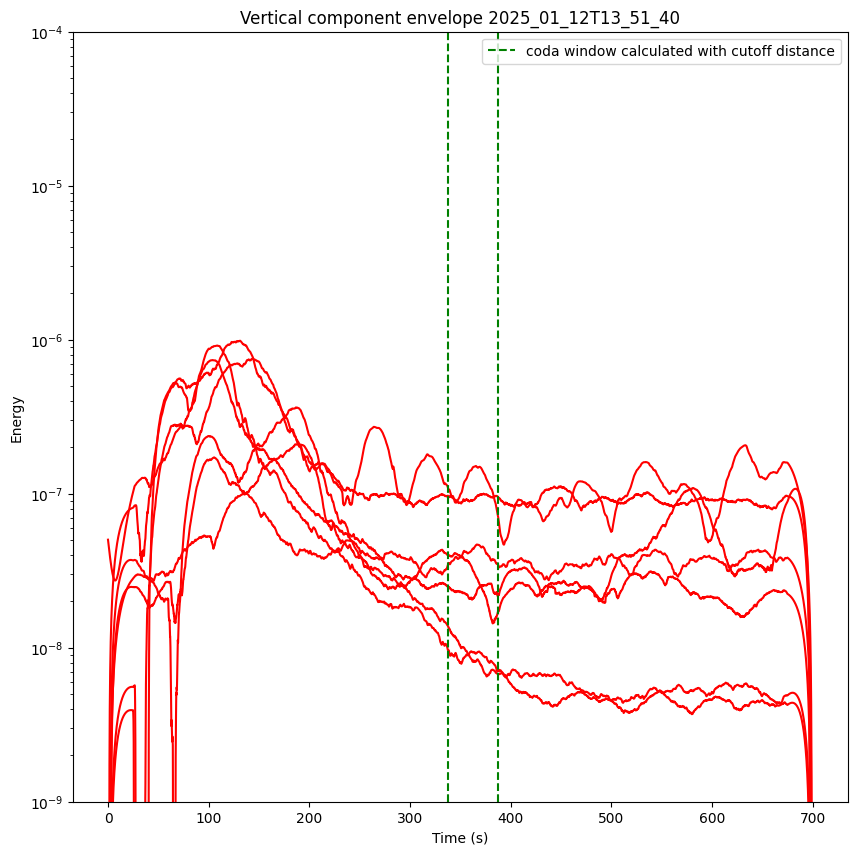

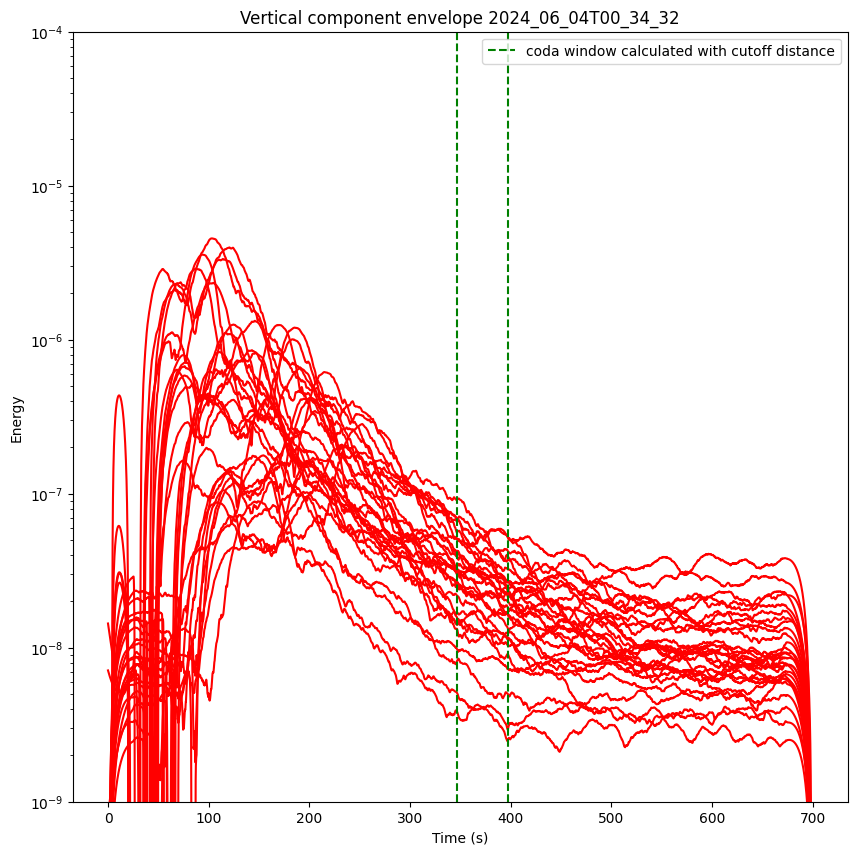

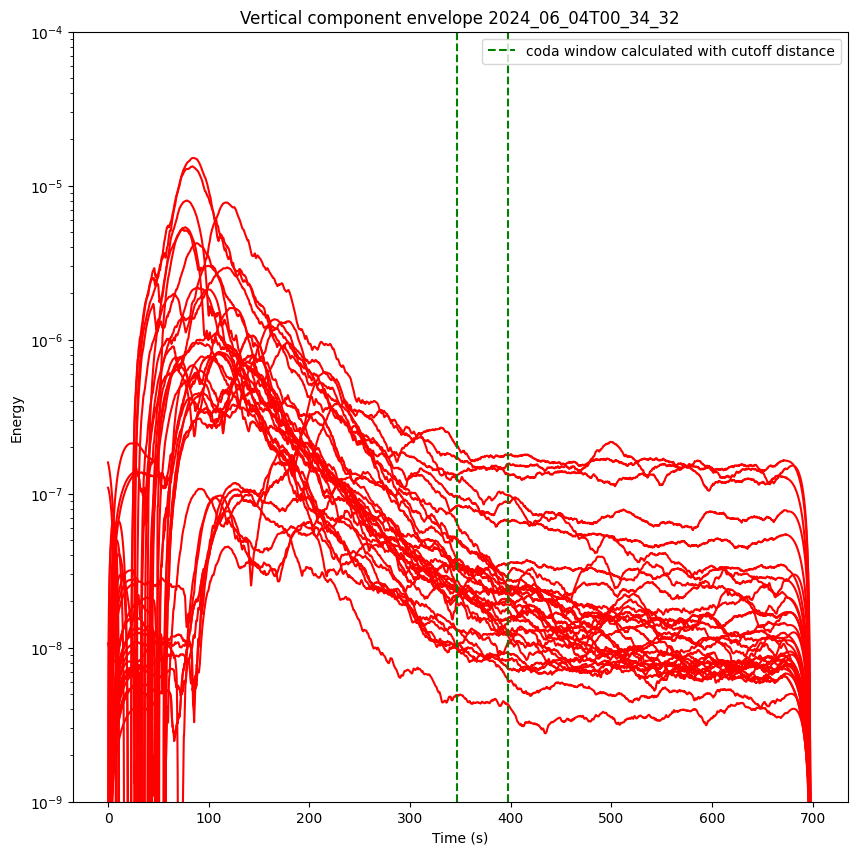

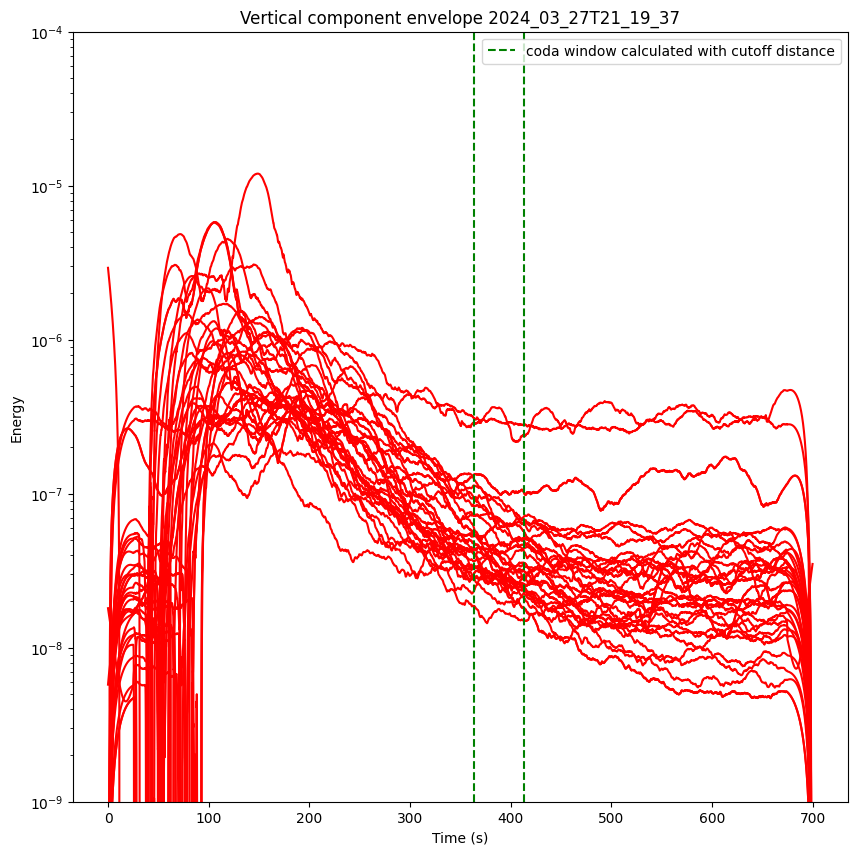

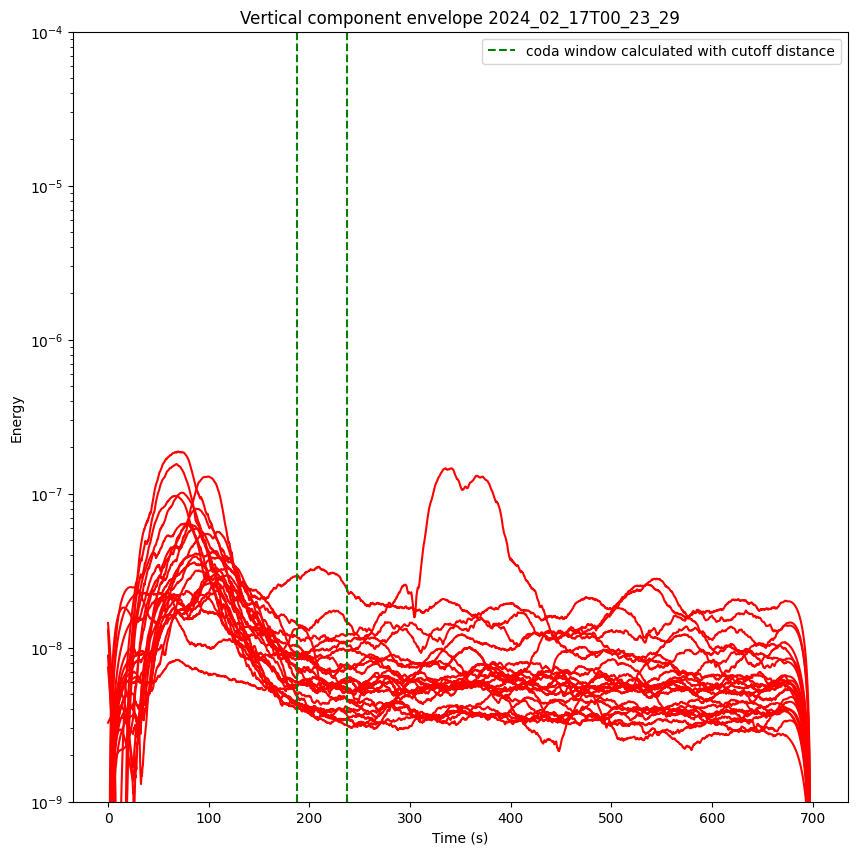

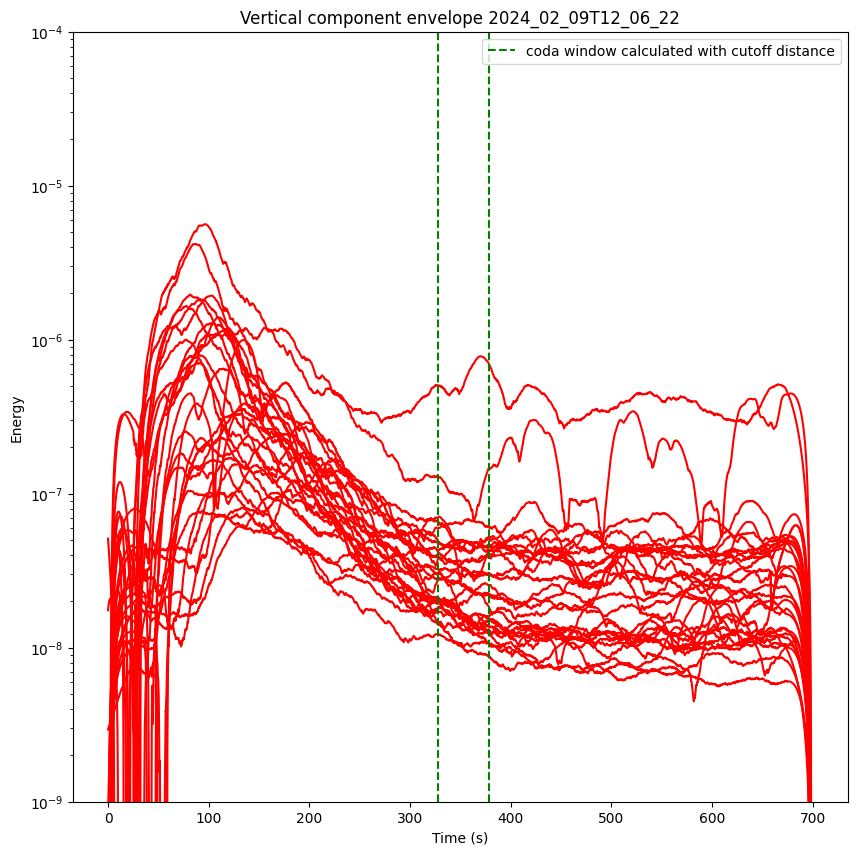

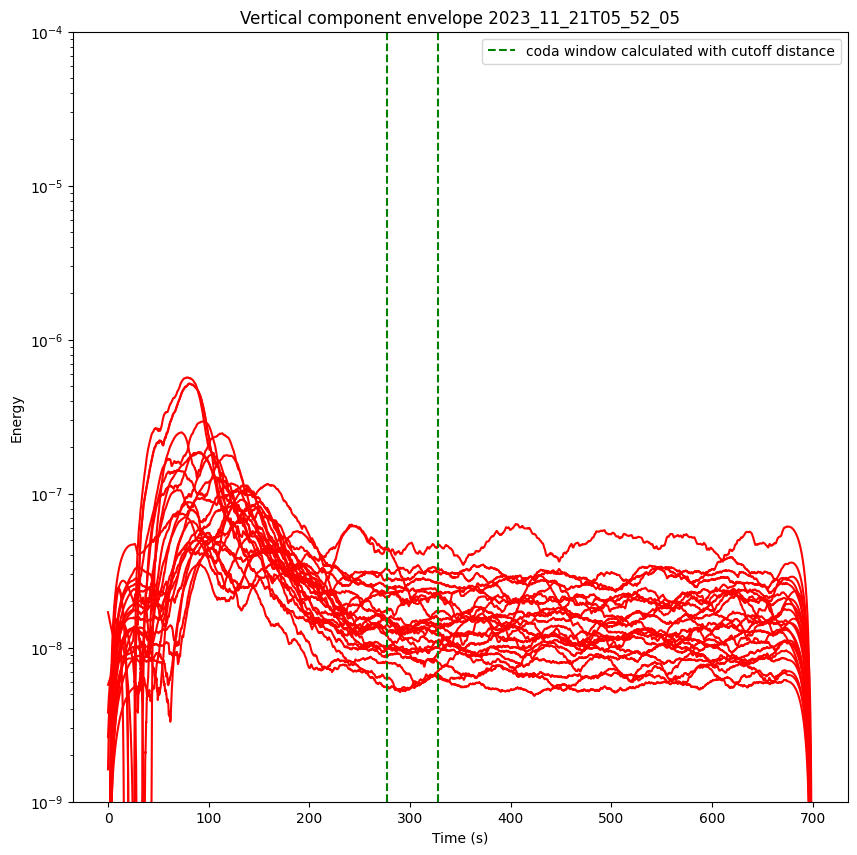

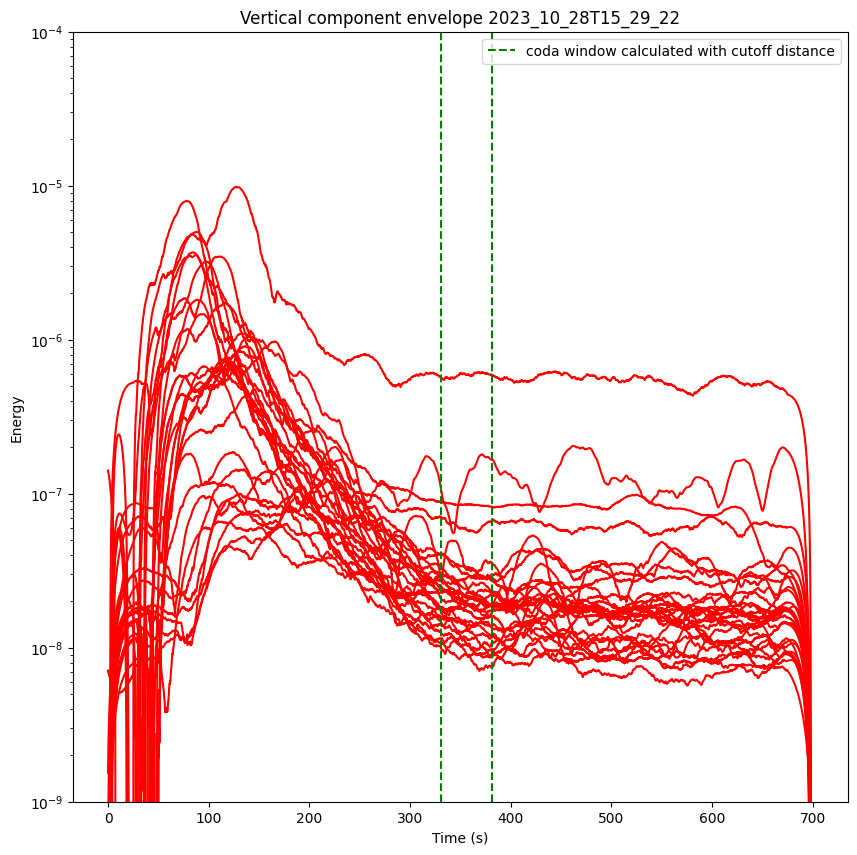

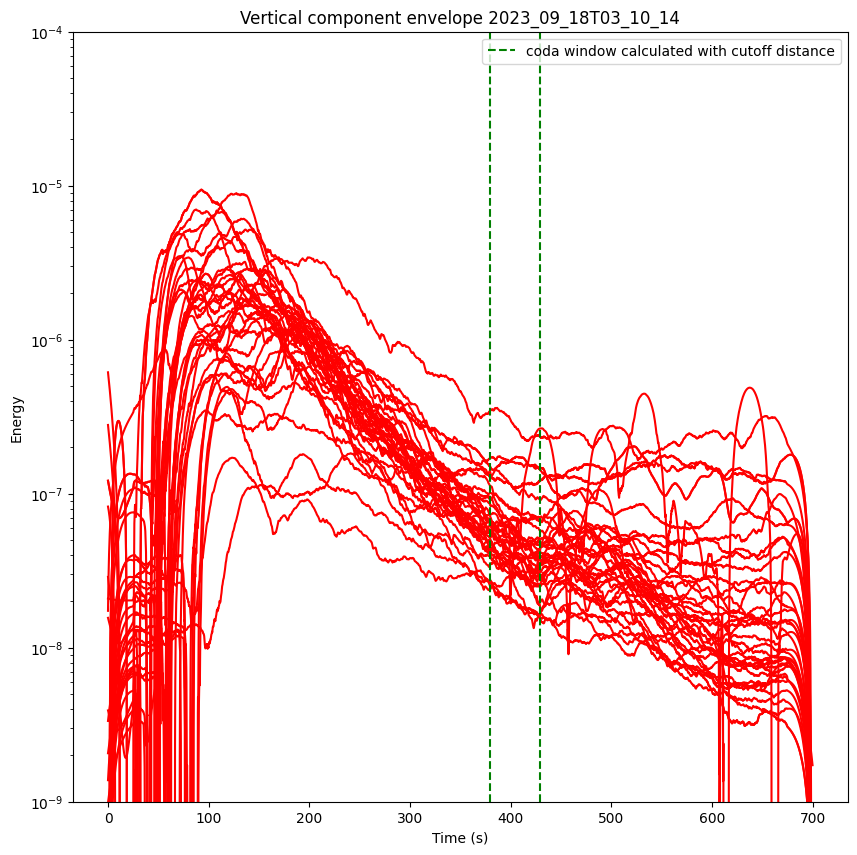

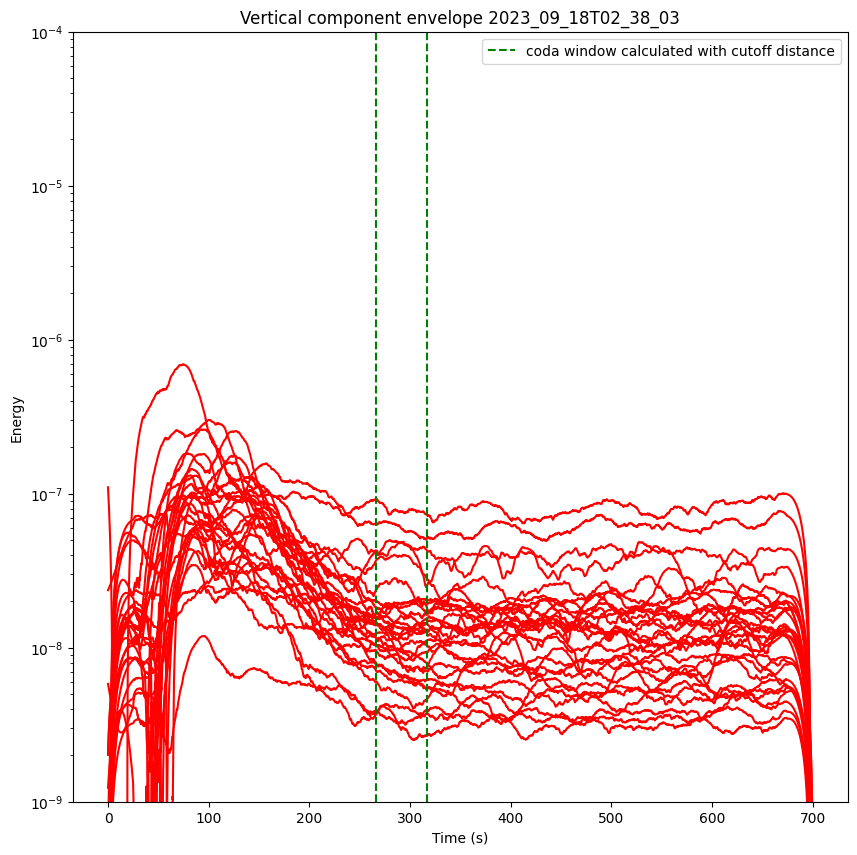

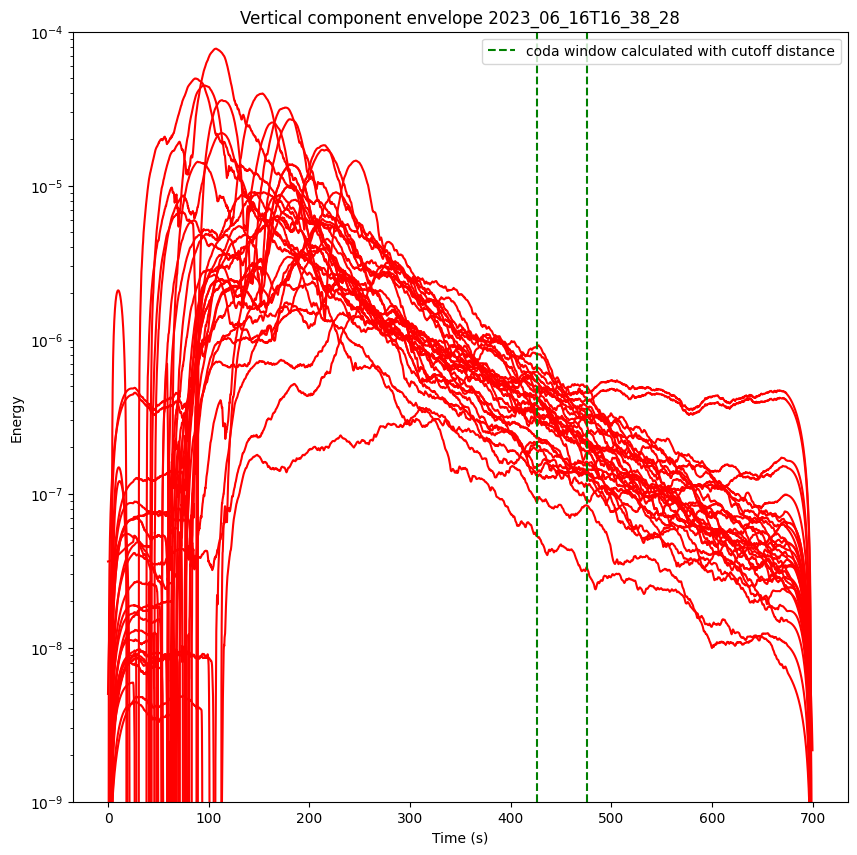

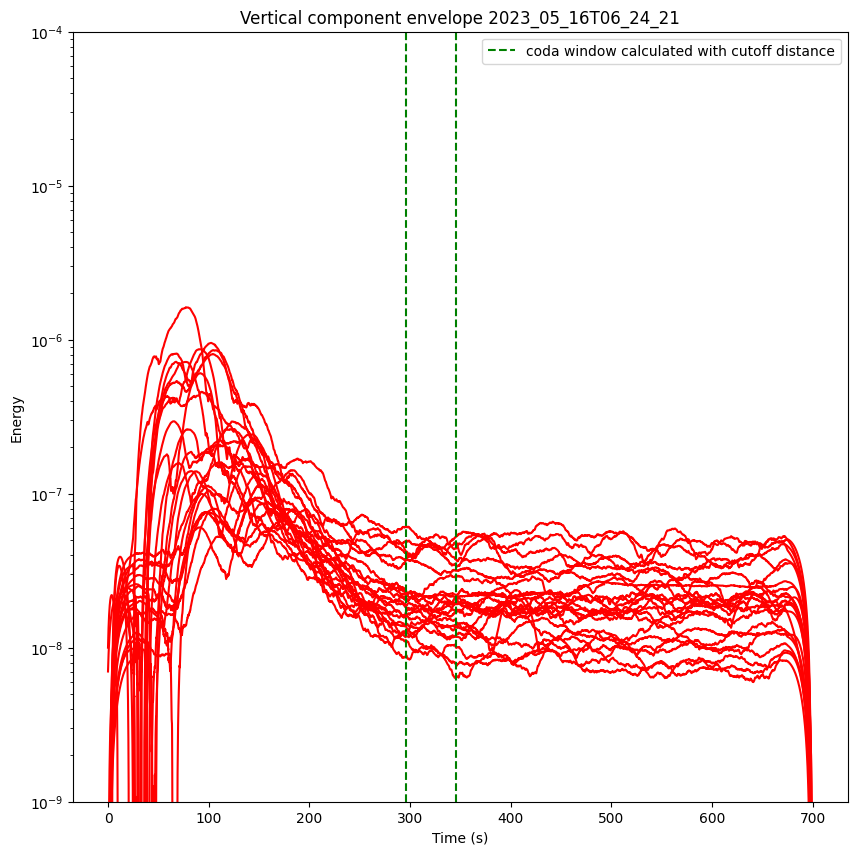

In [ ]:
datacenters =['RESIF','ODC','ETH','INGV','GEOFON', 'IRIS', 'ICGC']#,'BGR']
directory='C:/UGA/Stage/Data/'
distmin=1.9
distmax=10.
eq_list = pd.read_csv('/home/schreinl/Stage/Data/trial.csv')

for event in range(len(eq_list)):
    print("event" ,event, " out of ", len(eq_list))
    start = UTCDateTime(eq_list["time"][event])
    end = start + 700
    eq_lon = float(eq_list["longitude"][event])
    eq_lat = float(eq_list["latitude"][event])
    st_all, stations_all, plot = big_downloader2(datacenters, start, end, eq_lon, eq_lat, distmin, distmax, directory, plot=False)
    time_string = UTCDateTime.strftime(start, format="%Y_%m_%dT%H_%M_%S")

    st_plot_filt_all=st_all.copy()
    fmin=1  
    fmax=5
    st_plot_filt_all.filter("bandpass", freqmin=fmin, freqmax=fmax)


    st_envelope = obspy.Stream()
    smallest = 7000
    for tr in st_plot_filt_all:
        data_envelope = envelope_calculator(tr.data)
        npts = tr.stats.npts
        if npts >= smallest:
            samprate = tr.stats.sampling_rate
            t = np.arange(0, npts / samprate, 1 / samprate)
            tr_envelope = obspy.Trace(data=data_envelope, header=tr.stats)
            st_envelope.append(tr_envelope)



    snr_threshold = 2
    eq_start = start



    filtered_stations_with_SNR, stations_with_SNR, distance_dict, tcoda_test, filtered_st, stations_with_amps, amp_plot = SNR_all(stations_all, st_plot_filt_all, Dtmin_Pn, Dtmax_Pn, Dtmin_Sn, Dtmax_Sn, vLg_min,vLg_max,vPg_min, vPg_max, tminCoda, tmaxCoda,
         Dtmin_Noise, Dtmax_Noise,eq_start,eq_lat,eq_lon,snr_threshold=snr_threshold,plot_SNR=False,plot_amps=True, wavecode="Lg_Coda",dB=True)

    for i,tr in enumerate(st_envelope):
        if tr.stats.station == stationref:
            idx_reference = i

    envelopes_amps, st_smooth = envelopes_routine1(time_string, st_envelope,coda_dist_start=tcoda_test, coda_dist_end=tcoda_test + 50, plotting=False)

    with open(f"/home/schreinl/Stage/Data/{time_string}/{time_string}_envelope_amps_fac_1.5_dict.txt", "w") as ampls:
        json.dump(envelopes_amps, ampls, indent=4)
    filtered_station_names = set(row[1] for row in filtered_stations_with_SNR) 
    filtered_smooth_stream = obspy.Stream()
    filtered_stream = obspy.Stream()
    for trace in st_smooth:
        if trace.stats.station in filtered_station_names:
            filtered_smooth_stream.append(trace)
    for trace in st_envelope:
        if trace.stats.station in filtered_station_names:
            filtered_stream.append(trace)
    plot_filtered_smoothed = smooth_plot_envelope(time_string, 50,filtered_stream,tmincoda_dist=tcoda_test, tmaxcoda_dist=tcoda_test+50,plotshow=False,savefig=True)

In [5]:

eq_list = pd.read_csv('/home/schreinl/Stage/Data/trial.csv')


station_tests = ["SSB", "ECH", "CHIF", "BALS", "CURIE", "ABJF", "PLYF"]
amplitudes_dict = {station: [] for station in station_tests}

for i in range(len(eq_list)):
    #print(f"Processing event {i}")
    start = UTCDateTime(eq_list["time"][i])
    time_string = UTCDateTime.strftime(start, format="%Y_%m_%dT%H_%M_%S")
    
    try:
        with open(f"/home/schreinl/Stage/Data/{time_string}/{time_string}_envelope_amps_fac_1.5_dict.txt", "r") as file:
            amp_dict = json.load(file)

        for station in station_tests:
            if station in amp_dict:
                amplitudes_dict[station].append(amp_dict[station]["amplitude"])
            else:
                #print(f"Skipping event {i} for station '{station}': Not found.")
                amplitudes_dict[station].append(None)
    except FileNotFoundError:
        #print(f"Skipping event {i}: File missing.")
        for station in station_tests:
            amplitudes_dict[station].append(None)

print(amplitudes_dict)


{'SSB': [2.2223026360765018e-10, 3.0699445596962523e-10, 3.0699445596962523e-10, 4.1765666211575026e-10, 1.2177049479732322e-10, 2.5020387309100453e-10, None, 2.3294687737868244e-10, 4.2831820302306407e-10, 1.3027056065350946e-10, None, None, None, None, None], 'ECH': [1.3158798356461504e-10, None, None, 5.999468699234863e-10, 1.6848305560989953e-10, 2.5856912466518546e-10, 6.913622960201138e-10, 4.13028833783813e-10, 7.55276221780251e-10, 3.022244381725525e-10, 1.0590803863758283e-08, 1.618015640812225e-10, None, None, None], 'CHIF': [2.3944051509240354e-10, 4.1367519462638466e-10, 4.1367519462638466e-10, 7.464280008373999e-10, 1.3844417968698157e-10, 4.461535566859775e-10, 3.7954958309766074e-10, 4.787649671847305e-10, 5.681297058284995e-10, 2.355837009569443e-10, None, 3.807390487249148e-10, None, None, None], 'BALS': [3.114474783845134e-10, 4.598064841119707e-10, 4.598064841119707e-10, 5.180972243111756e-10, 1.9370388162980136e-10, None, 2.942312776146473e-10, 2.9900414462788495e-1

In [6]:
from obspy import UTCDateTime
import json

# List of stations
station_tests = ["SSB", "ECH", "CHIF", "BALS", "CURIE", "ABJF", "PLYF"]

# Initialize dictionary to store (event_time, amplitude) tuples
amplitudes_dict = {station: [] for station in station_tests}

# Loop over events
for i in range(len(eq_list)):
    start = UTCDateTime(eq_list["time"][i])
    time_string = UTCDateTime.strftime(start, format="%Y_%m_%dT%H_%M_%S")
    
    try:
        # Load amplitude dictionary from file
        with open(f"/home/schreinl/Stage/Data/{time_string}/{time_string}_envelope_amps_fac_1.5_dict.txt", "r") as file:
            amp_dict = json.load(file)

        # Store (event_time, amplitude) for each station
        for station in station_tests:
            if station in amp_dict:
                amplitudes_dict[station].append((time_string, amp_dict[station]["amplitude"]))
            else:
                amplitudes_dict[station].append((time_string, None))  # Store None if missing
    except FileNotFoundError:
        # If the file is missing, store None for all stations
        for station in station_tests:
            amplitudes_dict[station].append((time_string, None))

# Print dictionary
print(amplitudes_dict)


{'SSB': [('2025_01_12T13_51_40', 2.2223026360765018e-10), ('2024_06_04T00_34_32', 3.0699445596962523e-10), ('2024_06_04T00_34_32', 3.0699445596962523e-10), ('2024_03_27T21_19_37', 4.1765666211575026e-10), ('2024_02_17T00_23_29', 1.2177049479732322e-10), ('2024_02_09T12_06_22', 2.5020387309100453e-10), ('2023_11_21T05_52_05', None), ('2023_10_28T15_29_22', 2.3294687737868244e-10), ('2023_09_18T03_10_14', 4.2831820302306407e-10), ('2023_09_18T02_38_03', 1.3027056065350946e-10), ('2023_06_16T16_38_28', None), ('2023_05_16T06_24_21', None), ('2023_03_22T14_50_33', None), ('2023_03_09T19_13_57', None), ('2023_03_09T19_08_07', None)], 'ECH': [('2025_01_12T13_51_40', 1.3158798356461504e-10), ('2024_06_04T00_34_32', None), ('2024_06_04T00_34_32', None), ('2024_03_27T21_19_37', 5.999468699234863e-10), ('2024_02_17T00_23_29', 1.6848305560989953e-10), ('2024_02_09T12_06_22', 2.5856912466518546e-10), ('2023_11_21T05_52_05', 6.913622960201138e-10), ('2023_10_28T15_29_22', 4.13028833783813e-10), ('2

In [7]:
for station in amplitudes_dict:
    amplitudes = [amp for _, amp in amplitudes_dict[station]]  
    recorded_count = sum(amp is not None for amp in amplitudes)
    total_events = len(amplitudes_dict["ECH"])  
    
    print(f"Station {station} recorded {recorded_count} earthquakes out of {total_events}")



Station SSB recorded 9 earthquakes out of 15
Station ECH recorded 10 earthquakes out of 15
Station CHIF recorded 11 earthquakes out of 15
Station BALS recorded 11 earthquakes out of 15
Station CURIE recorded 12 earthquakes out of 15
Station ABJF recorded 11 earthquakes out of 15
Station PLYF recorded 12 earthquakes out of 15


Mean Ratio (ABJF / CHIF): 0.34750
Standard Deviation: 0.05300
Median: 0.35926
Min Ratio: 0.26451
Max Ratio: 0.42611


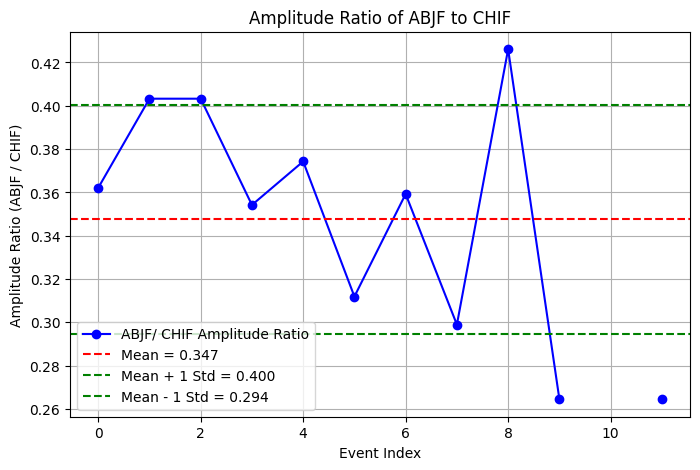

In [8]:
station1 = "ABJF"       #
station2 = "CHIF"       # equal to the reference station
denom_amplitudes = np.array([amp for _, amp in amplitudes_dict[station1]], dtype=np.float64)
counter_amplitudes = np.array([amp for _, amp in amplitudes_dict[station2]], dtype=np.float64)

denom_amplitudes = np.where(denom_amplitudes == None, np.nan, denom_amplitudes)
counter_amplitudes = np.where(counter_amplitudes == None, np.nan, counter_amplitudes)

ratio = np.divide(denom_amplitudes, counter_amplitudes, out=np.full_like(denom_amplitudes, np.nan), where=(counter_amplitudes != 0))
valid_ratios = ratio[~np.isnan(ratio)]
mean_ratio = np.nanmean(valid_ratios) 
std_ratio = np.nanstd(valid_ratios)
median_ratio = np.nanmedian(valid_ratios)
min_ratio = np.nanmin(valid_ratios) 
max_ratio = np.nanmax(valid_ratios)

print(f"Mean Ratio ({station1} / {station2}): {mean_ratio:.5f}")
print(f"Standard Deviation: {std_ratio:.5f}")
print(f"Median: {median_ratio:.5f}")
print(f"Min Ratio: {min_ratio:.5f}")
print(f"Max Ratio: {max_ratio:.5f}")

plt.figure(figsize=(8, 5))
plt.plot(ratio, marker="o", linestyle="-", color="b", label=f"{station1}/ {station2} Amplitude Ratio")
plt.axhline(mean_ratio, color="r", linestyle="--", label=f"Mean = {mean_ratio:.3f}")
plt.axhline(mean_ratio + std_ratio, color="g", linestyle="--", label=f"Mean + 1 Std = {mean_ratio + std_ratio:.3f}")
plt.axhline(mean_ratio - std_ratio, color="g", linestyle="--", label=f"Mean - 1 Std = {mean_ratio - std_ratio:.3f}")

plt.xlabel("Event Index")
plt.ylabel(f"Amplitude Ratio ({station1} / {station2})")
plt.title(f"Amplitude Ratio of {station1} to {station2}")
plt.legend()
plt.grid(True)
plt.show()


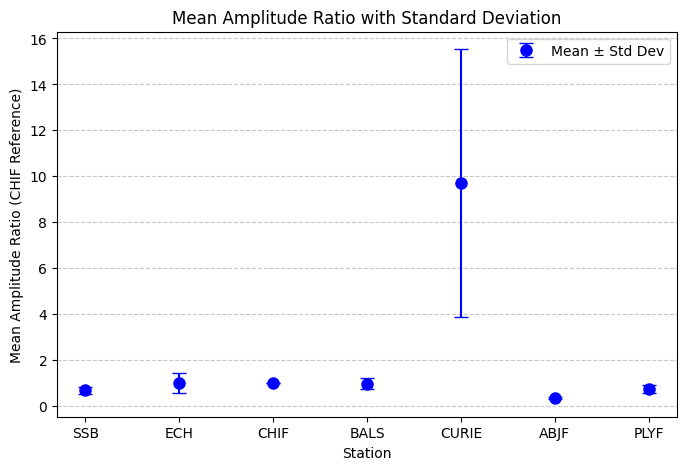

In [13]:


station2 = "CHIF"

stations = ["ABJF", "PLYF", "BALS"]
stations = station_tests
amplitude_ratios = {}

for station1 in stations:
    denom_amplitudes = np.array([amp for _, amp in amplitudes_dict[station1]], dtype=np.float64)
    counter_amplitudes = np.array([amp for _, amp in amplitudes_dict[station2]], dtype=np.float64)

    denom_amplitudes = np.where(denom_amplitudes == None, np.nan, denom_amplitudes)
    counter_amplitudes = np.where(counter_amplitudes == None, np.nan, counter_amplitudes)

    ratio = np.divide(denom_amplitudes, counter_amplitudes, out=np.full_like(denom_amplitudes, np.nan), where=(counter_amplitudes != 0))
    valid_ratios = ratio[~np.isnan(ratio)]
    
    amplitude_ratios[station1] = {
        "mean": np.nanmean(valid_ratios),
        "std": np.nanstd(valid_ratios),
    }

stations_list = list(amplitude_ratios.keys())
mean_values = [amplitude_ratios[st]["mean"] for st in stations_list]
std_values = [amplitude_ratios[st]["std"] for st in stations_list]

plt.figure(figsize=(8, 5))
plt.errorbar(stations_list, mean_values, yerr=std_values, fmt='o', capsize=5, markersize=8, color="b", label="Mean ± Std Dev")

plt.xlabel("Station")
plt.ylabel(f"Mean Amplitude Ratio ({station2} Reference)")
plt.title(f"Mean Amplitude Ratio with Standard Deviation")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()
